In [1]:
import pandas as pd
import graph_tool.all as gt
import networkx as nx
import numpy as np
import seaborn as sns

# Centrality measures

 - IMDB crew dataset and basic title dataset: https://datasets.imdbws.com/
 
 Centrality measures:
 - betweenness
 - closenness
 - page rank
 
 Connected components
 Community detection

In [2]:
title = pd.read_csv("../data/title.crew.tsv", delimiter='\t', na_values='\\N')

In [3]:
basics = pd.read_csv("../data/title.basics.tsv", delimiter='\t', na_values='\\N')

/Users/rdora/miniconda3/envs/clase/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
names = pd.read_csv('../data/name.basics.tsv', delimiter='\t', na_values='\\N')

In [ ]:
basics['startYear'] = basics['startYear'].astype('float')

Let's work only with movies from 1980 to date

In [20]:
basics = basics[basics['titleType'] == 'movie']
basics = basics[basics['startYear'].between(1980, 2020)]

Adult movies

In [30]:
basics = basics[basics['genres'].notna()]

In [33]:
adult = basics[basics['genres'].str.contains('Adult')]

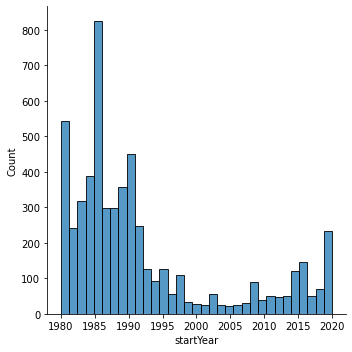

In [34]:
sns.displot(adult['startYear'])

string -> lista (size: # of commas + 1) using split

In [50]:
adult.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers
0,tt0068745,movie,Intime Liebschaften,Intime Liebschaften,1.0,1980.0,NaN,93.0,"Adult,Comedy",nm0082420,NaN
1,tt0078733,movie,Adolescentes au pensionnat,Adolescentes au pensionnat,1.0,1981.0,NaN,83.0,Adult,nm0344923,nm0344923
2,tt0078929,movie,Cameriera senza... malizia,Cameriera senza... malizia,1.0,1980.0,NaN,103.0,Adult,"nm0300415,nm0648839","nm0135375,nm0597265"
3,tt0079642,movie,Erotic Nights of the Living Dead,Le notti erotiche dei morti viventi,1.0,1980.0,NaN,88.0,"Adult,Horror",nm0001090,nm0247642
4,tt0079720,movie,El regreso de Eva Man,El regreso de Eva Man,1.0,1982.0,NaN,88.0,"Adult,Comedy",nm0881754,"nm0145626,nm0194878"


In [41]:
adult = adult.merge(title, how='left')

Network between writers and directors

In [86]:
adult = adult.dropna(subset=['directors', 'writers'])

In [89]:
adult['directors'] = adult['directors'].apply(lambda x: x.split(','))
adult['writers'] = adult['writers'].apply(lambda x: x.split(','))

In [92]:
adult = adult.explode('directors')
adult = adult.explode('writers')

In [103]:
dir_and_writ = set(adult['directors']) | set(adult['writers'])

In [106]:
names = names[names['nconst'].isin(dir_and_writ)]

In [105]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10777803 entries, 0 to 10777802
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   nconst             object 
 1   primaryName        object 
 2   birthYear          float64
 3   deathYear          float64
 4   primaryProfession  object 
 5   knownForTitles     object 
dtypes: float64(2), object(4)
memory usage: 493.4+ MB


# Create the graph

In [109]:
edges = adult[['directors', 'writers']]

In [111]:
edges.shape

(2486, 2)

In [115]:
edges = edges.groupby(['directors', 'writers']).size().rename('weight').reset_index()

In [122]:
g = gt.Graph(directed=False)
weight = g.new_edge_property('int')
# vertex property con los 'labels' de los nodos
nconst = g.add_edge_list(edges.values, eprops=[weight], hashed=True)

## Remove self loops and parallel edges

In [135]:
cc, hist = gt.label_components(g)

In [157]:
gcc = gt.label_largest_component(g)

In [161]:
sl = gt.label_self_loops(g, mark_only=True)

In [170]:
sl = gt.label_self_loops(g, mark_only=True)
sl.a = 1 - sl.a

In [172]:
pe = gt.label_parallel_edges(g, mark_only=True)
pe.a = 1 - pe.a

In [176]:
pe.a = pe.a & sl.a

In [178]:
h = gt.GraphView(g, vfilt=gcc, efilt=pe)

In [180]:
pos = gt.sfdp_layout(g)

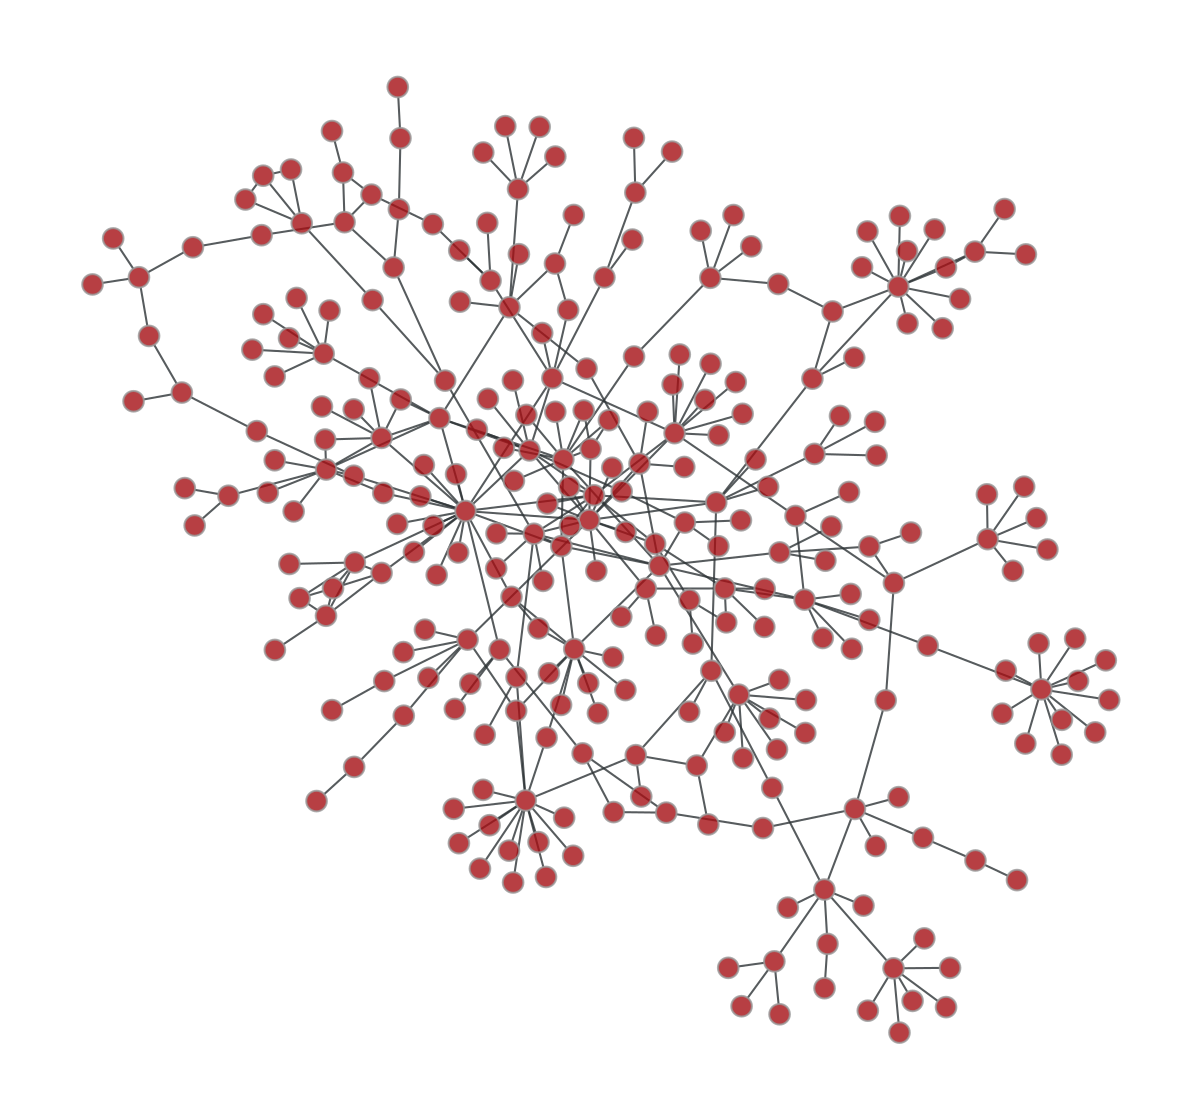

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8ea9e42190, at 0x7f8f1dd45e80>

In [183]:
gt.graph_draw(h, pos=pos)

## Centraliry measures
    - Page Rank
    - Betweenness
    - Closeness

In [184]:
vb, eb = gt.betweenness(h)

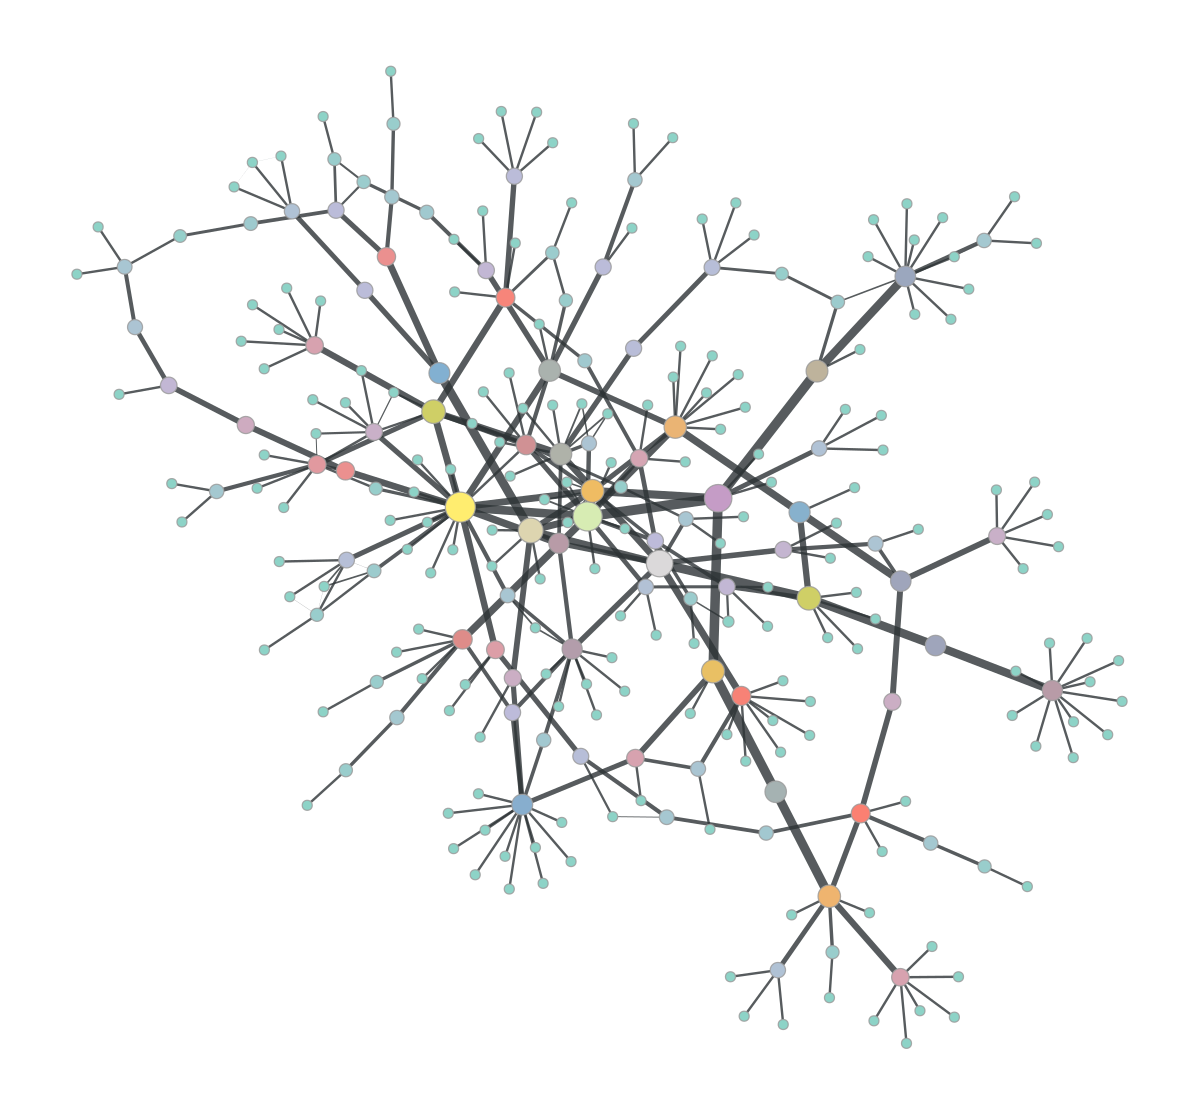

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8ea9e42190, at 0x7f8f1dd45e80>

In [187]:
gt.graph_draw(h, pos=pos,
              edge_pen_width=gt.prop_to_size(eb, mi=0, ma=5),
              vertex_size=gt.prop_to_size(vb, mi=5, ma=15),
              vertex_fill_color=vb)

In [189]:
vc = gt.closeness(h)

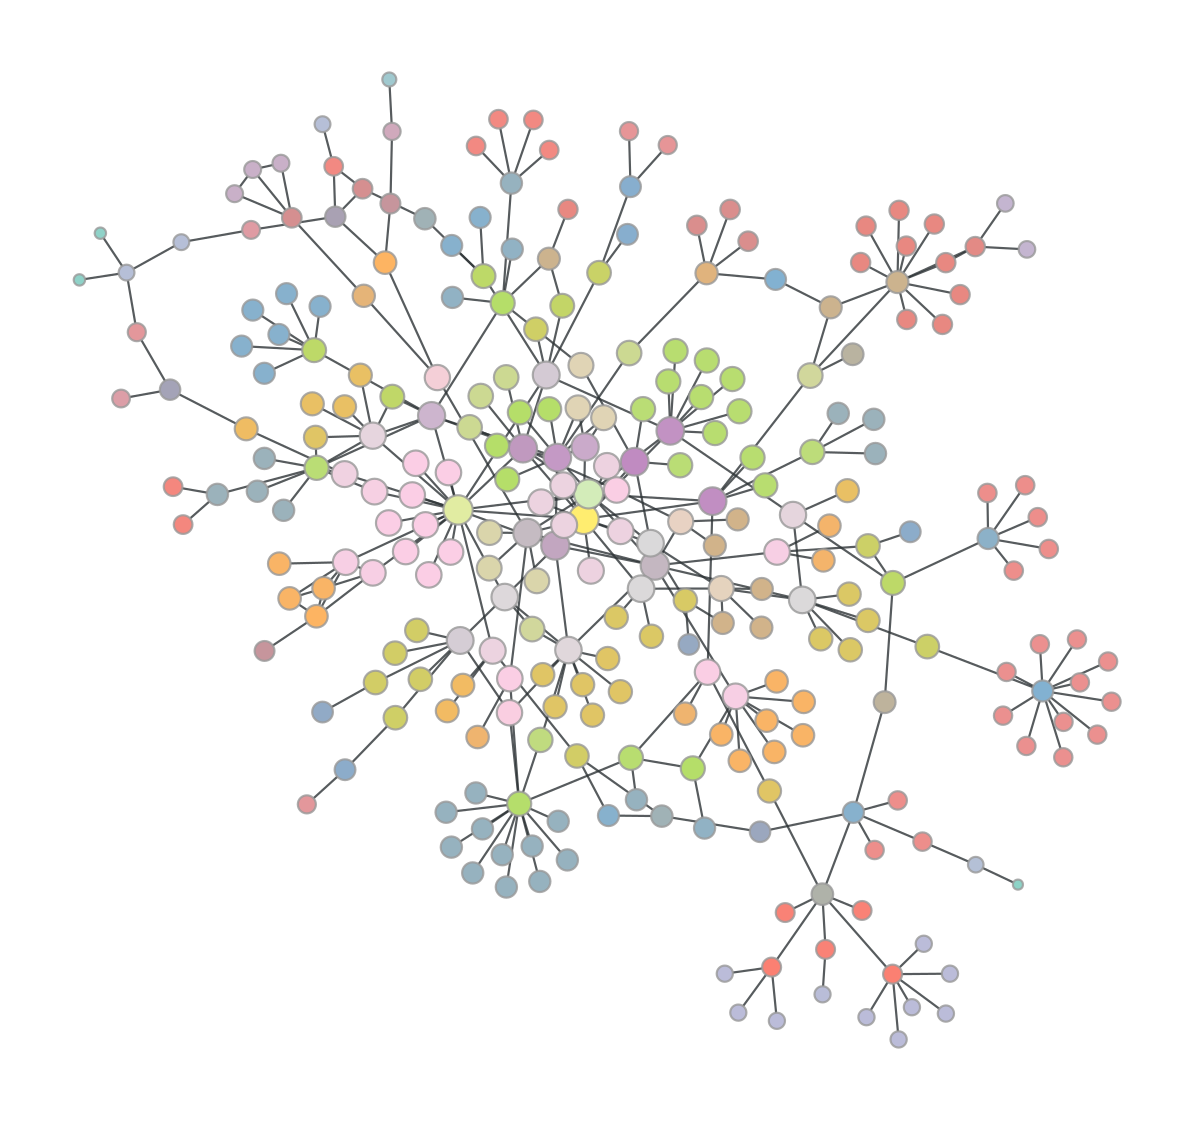

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8ea9e42190, at 0x7f8f1dd45e80>

In [190]:
gt.graph_draw(h, pos=pos,
              vertex_size=gt.prop_to_size(vc, mi=5, ma=15),
              vertex_fill_color=vc)

In [191]:
vpr = gt.pagerank(h)

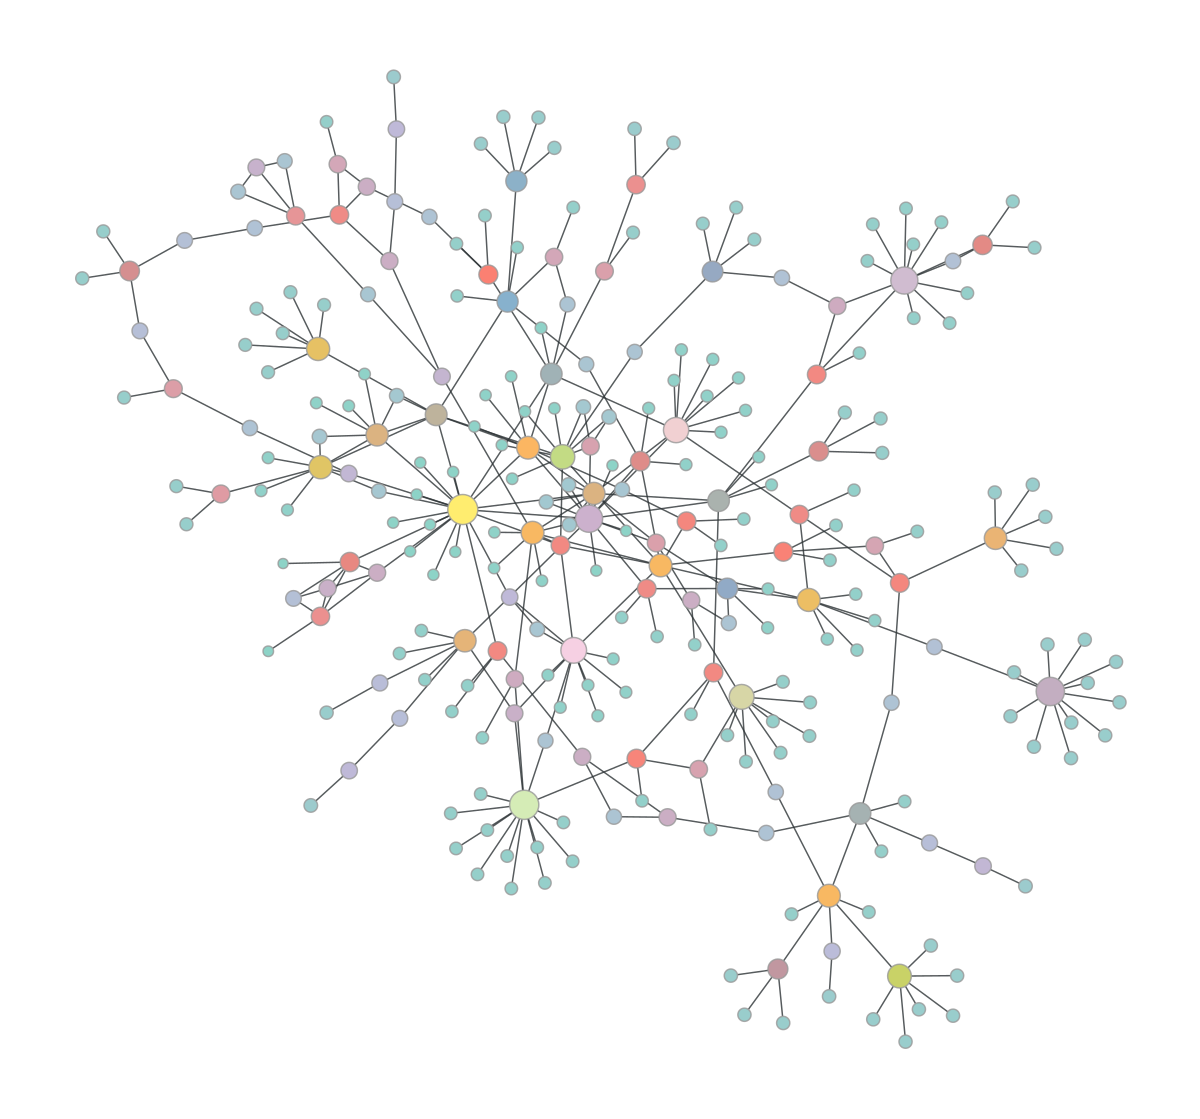

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8ea9e42190, at 0x7f8f1dd45e80>

In [193]:
gt.graph_draw(h, pos=pos,
              vertex_size=gt.prop_to_size(vpr, mi=5, ma=15),
              vertex_fill_color=vpr)

In [194]:
deg = h.degree_property_map('out', weight=weight)

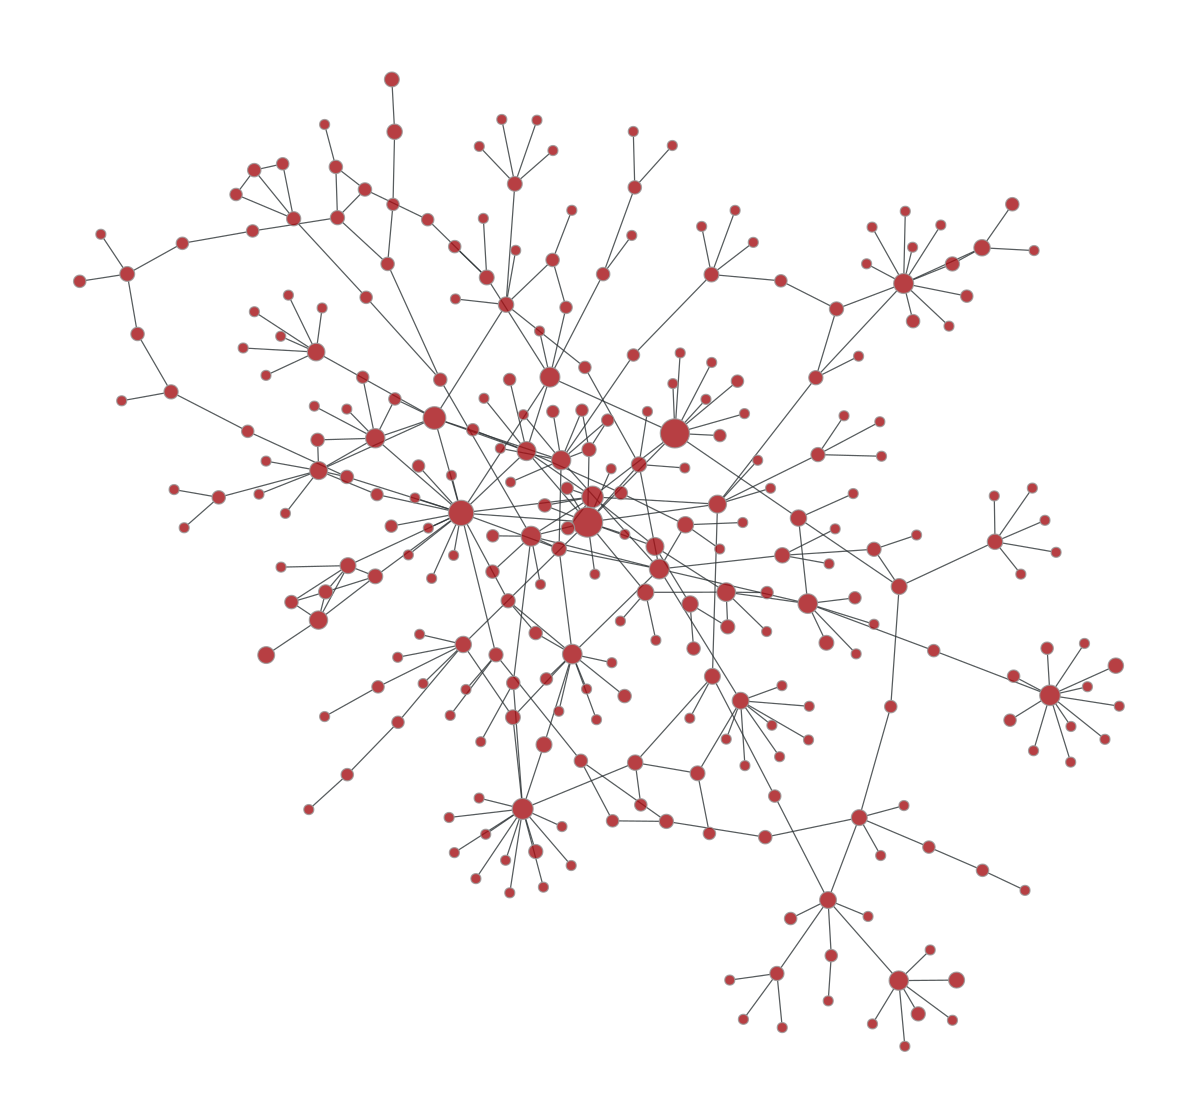

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8ea9e42190, at 0x7f8f1dd45e80>

In [195]:
gt.graph_draw(h, pos=pos,
              vertex_size=gt.prop_to_size(deg, mi=5, ma=15))

In [196]:
data = []
for v in h.vertices():
    b = vb[v]
    c = vc[v]
    pr = vpr[v]
    d = deg[v]
    name = nconst[v]
    data.append([name, b, c, pr, d])
central = pd.DataFrame(data, columns=['nconst', 'betweenness',
                                      'closenness', 'page_rank',
                                      'degree'])

In [197]:
central = central.merge(names[['nconst', 'primaryName', 'birthYear']], how='left')

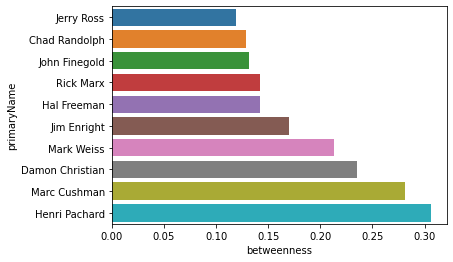

In [198]:
var = 'betweenness'
ax = sns.barplot(x=var,
            y='primaryName',
            data=central.sort_values(var).iloc[-10:])

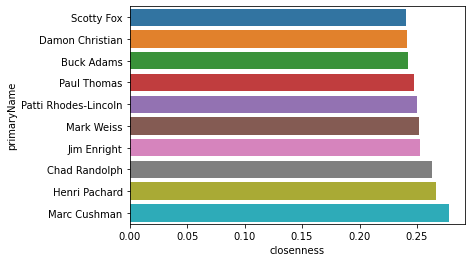

In [199]:
var = 'closenness'
ax = sns.barplot(x=var,
            y='primaryName',
            data=central.sort_values(var).iloc[-10:])

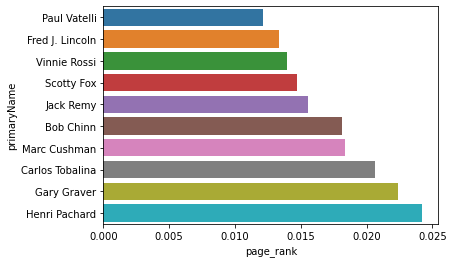

In [200]:
var = 'page_rank'
ax = sns.barplot(x=var,
            y='primaryName',
            data=central.sort_values(var).iloc[-10:])

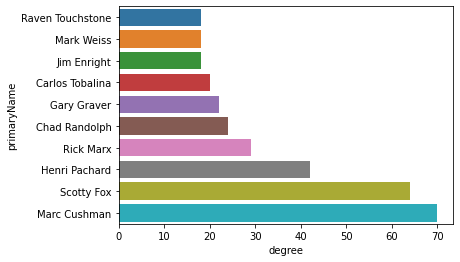

In [201]:
var = 'degree'
ax = sns.barplot(x=var,
            y='primaryName',
            data=central.sort_values(var).iloc[-10:])

## Communities

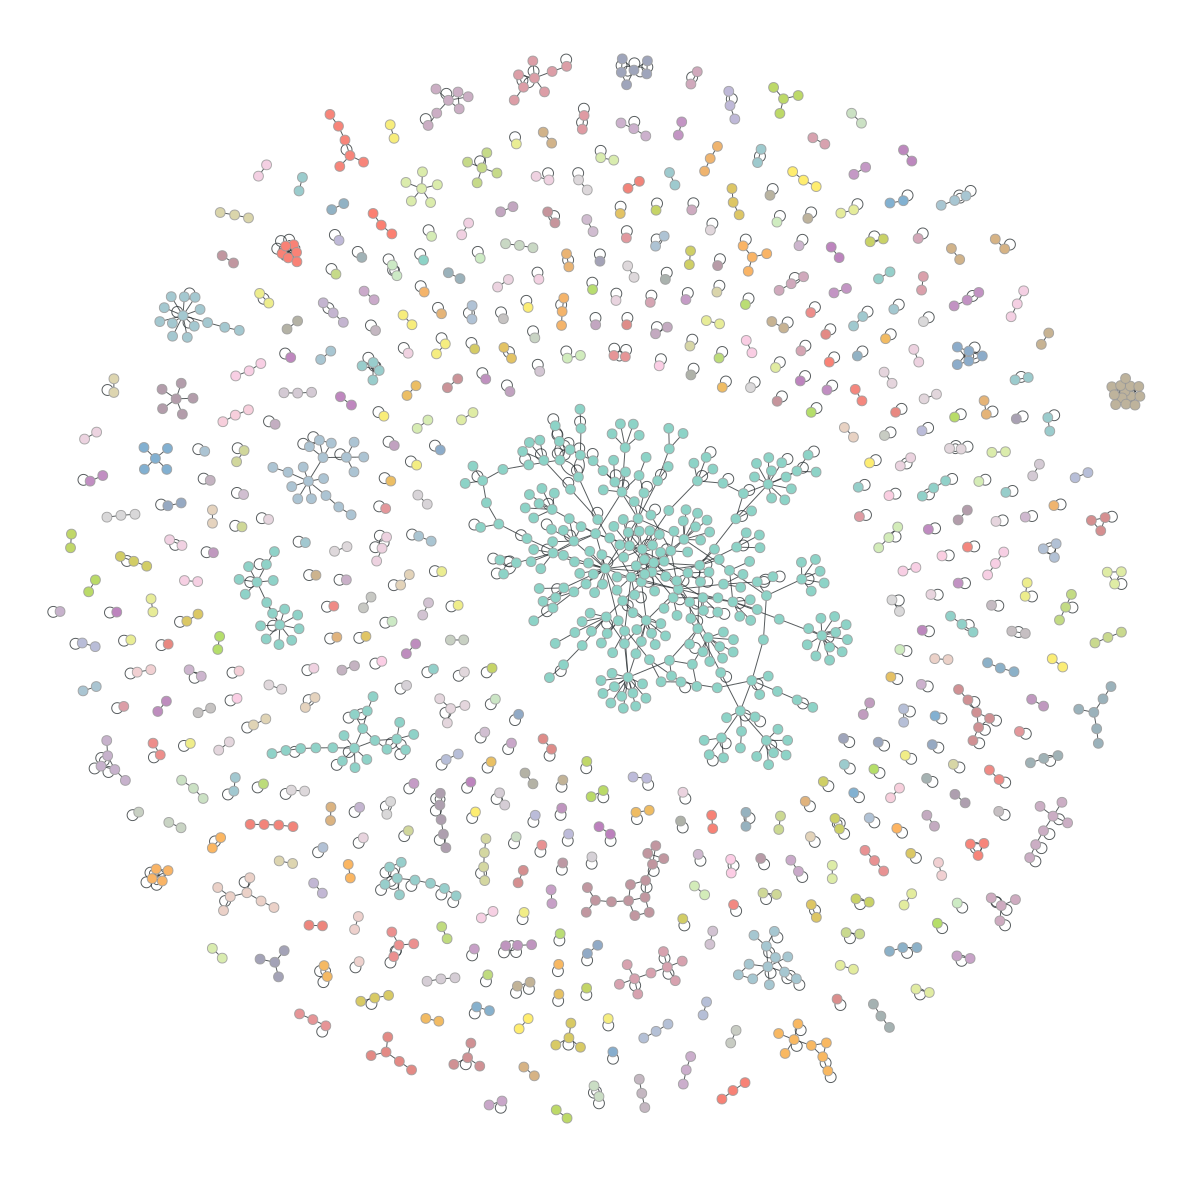

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8ea9e42190, at 0x7f8f1dd45e80>

In [202]:
gt.graph_draw(g, pos=pos, vertex_fill_color=cc)

In [203]:
nodes = []
connected_components = []
for v in g.iter_vertices():
    nodes.append(nconst[v])
    connected_components.append(cc[v])
df_cc = pd.DataFrame({'nconst': nodes, 'cc': connected_components})

In [204]:
df_cc = df_cc.merge(names, how='left')

In [205]:
df_cc['cc'].value_counts()

0      276
3       20
29      19
2       17
22      14
      ... 
153      1
44       1
151      1
303      1
75       1
Name: cc, Length: 438, dtype: int64

In [206]:
df_cc[df_cc['cc']==3]

,nconst,cc,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
17,nm0001238,3,Jesús Franco,1930.0,2013.0,"writer,director,actor","tt0067846,tt0064338,tt0086428,tt0109441"
18,nm0504244,3,Marius Lesoeur,1910.0,2003.0,"producer,writer,production_manager","tt0234946,tt0212049,tt0220633,tt0090642"
19,nm0626438,3,Robert de Nesle,1906.0,1978.0,"producer,writer,composer","tt0149700,tt0061516,tt1192134,tt0365253"
20,nm0739124,3,Lina Romay,1954.0,2012.0,"actress,assistant_director,director","tt0087976,tt0069745,tt0085355,tt0091526"
21,nm4986667,3,Robert Hugue,NaN,NaN,writer,tt2342037
150,nm0080580,3,Andrea Bianchi,1925.0,2013.0,"director,writer,assistant_director","tt0097845,tt0080693,tt0073470,tt0097589"
151,nm0716701,3,Piero Regnoli,1921.0,2001.0,"writer,director,actor","tt0058185,tt0211039,tt0204142,tt0183452"
152,nm0726742,3,Mauro Righi,NaN,NaN,"producer,writer,director","tt0154468,tt1242673,tt0189551,tt0072641"
153,nm3111073,3,André White,NaN,NaN,writer,"tt0080693,tt1281928"
359,nm0270413,3,Andrei Feher,1916.0,2003.0,"cinematographer,director,writer","tt0076287,tt0085676,tt0089827,tt1281928"


In [207]:
df_cc[df_cc['cc']==29]

,nconst,cc,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
128,nm0068871,29,Anthony Spinelli,1927.0,2000.0,"director,producer,actor","tt0082824,tt0196451,tt0085446,tt0081596"
129,nm0321017,29,Jacqueline Giroux,NaN,NaN,"actress,producer,camera_department","tt0090180,tt1434612,tt0104290,tt0331963"
130,nm0736825,29,Dean Rogers,NaN,NaN,"writer,production_designer","tt0085446,tt0125599,tt0134514,tt0127862"
131,nm0818881,29,Mitch Spinelli,NaN,NaN,"director,writer,producer","tt0082824,tt0127217,tt0082232,tt0139308"
132,nm7863130,29,Steven Flagg,NaN,NaN,writer,tt0085446
295,nm0213983,29,David DeCoteau,1962.0,NaN,"director,producer,cinematographer","tt0102728,tt6111830,tt5331084,tt2579034"
296,nm0861312,29,Chris Warfield,1927.0,1996.0,"actor,producer,director","tt0127187,tt0194905,tt1038020,tt0196092"
438,nm0371080,29,John Hayes,1930.0,2000.0,"director,writer,editor","tt0130637,tt0065812,tt0128484,tt0065383"
754,nm0781635,29,John Seeman,1943.0,NaN,"actor,producer,director","tt0127095,tt0126098,tt0129546,tt0079975"
755,nm0002005,29,Agatha Christie,1890.0,1976.0,"writer,camera_department","tt1349600,tt0051201,tt0029171,tt3402236"


In [221]:
adult[adult['writers']=='nm0674518']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers
543,tt0128060,movie,Erotic Adventures of Little Red Riding Hood,Le avventure erotix di Cappuccetto Rosso,1.0,1993.0,NaN,148.0,Adult,nm0516220,nm0674518


In [208]:
df_cc[df_cc['cc']==2]

,nconst,cc,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
8,nm0001090,2,Joe D'Amato,1936.0,1999.0,"director,cinematographer,camera_department","tt0089091,tt0085183,tt0083565,tt0068972"
9,nm0093688,2,Giacinto Bonacquisti,1937.0,2008.0,"writer,director,assistant_director","tt0126620,tt0202276,tt0078746,tt0248783"
10,nm0199309,2,Donna Dane,NaN,NaN,writer,"tt0493289,tt1935836,tt0160776,tt0271176"
11,nm0247642,2,George Eastman,1942.0,NaN,"writer,actor,director","tt0074201,tt0084424,tt0097874,tt0083565"
12,nm0265980,2,Lorenzo Falcone,NaN,NaN,"writer,assistant_director,script_department","tt0193141,tt0126683,tt0081026,tt0191841"
13,nm0528978,2,Robert Lyon,NaN,NaN,writer,"tt0203394,tt0272499,tt0140635,tt0125294"
14,nm0671037,2,Pino Pellegrino,NaN,NaN,"casting_director,writer,miscellaneous","tt0126719,tt0193033,tt1405810,tt3425034"
15,nm0811714,2,Michele Soavi,1957.0,NaN,"director,actor,assistant_director","tt0092576,tt0355295,tt0109592,tt0325011"
16,nm3802222,2,David Jones,NaN,NaN,writer,tt0275041
133,nm0069167,2,Max Bellocchio,NaN,NaN,"director,actor,writer","tt2400971,tt5057406,tt1065314,tt4171370"


In [209]:
state = gt.minimize_blockmodel_dl(g)

In [210]:
b = state.get_blocks()

In [211]:
blocks = []
nodes = []
for v in h.iter_vertices():
    blocks.append(b[v])
    nodes.append(nconst[v])
df_block = pd.DataFrame({'nconst': nodes, 'block': blocks})

In [212]:
df_block

,nconst,block
0,nm0000465,1
1,nm0036313,1
2,nm0267654,0
3,nm0414131,1
4,nm0416499,1
...,...,...
271,nm1804408,0
272,nm1527100,0
273,nm2460692,0
274,nm3229973,0


In [213]:
central = central.merge(df_block, how='left')

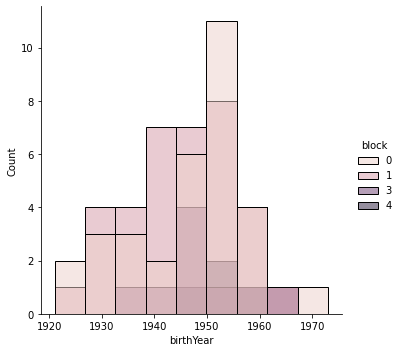

In [214]:
sns.displot(x='birthYear', hue='block', data=central[central['birthYear'].between(1900, 2000)])

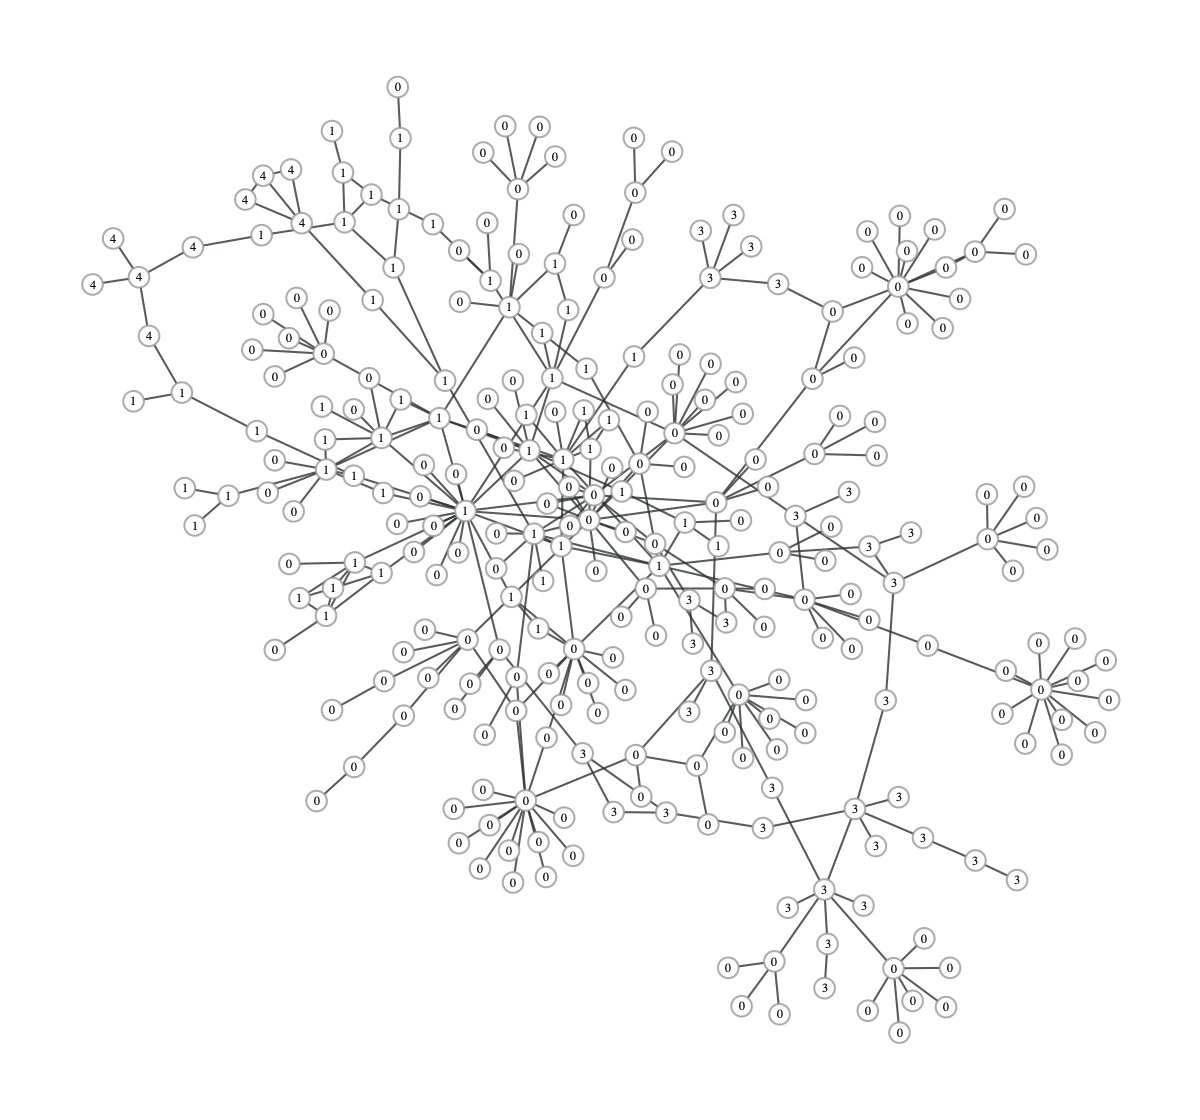

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f8ea9e42190, at 0x7f8f1dd45e80>

In [215]:
gt.graph_draw(h, pos=pos, vertex_text=b, vertex_fill_color='white')

In [216]:
central[central['block']==4]

,nconst,betweenness,closenness,page_rank,degree,primaryName,birthYear,block
41,nm0031301,0.017345,0.123098,0.006738,5,Bill Milling,NaN,4
42,nm0048909,0.005632,0.123263,0.003308,2,Scott Baker,1948.0,4
43,nm2067530,0.000000,0.109649,0.001975,2,Anthony Vincent,NaN,4
44,nm2535269,0.019522,0.136206,0.003367,3,Kang T. Kruel,NaN,4
45,nm2793239,0.000000,0.109649,0.001975,1,Bobby Pittsburgh,NaN,4
106,nm0217134,0.021672,0.148009,0.005260,4,Stephen Sayadian,1953.0,4
107,nm0821466,0.000013,0.129108,0.004048,3,Jerry Stahl,1953.0,4
232,nm0754160,0.000000,0.129047,0.002808,2,Mark S. Esposito,1956.0,4
275,nm5384247,0.000000,0.129047,0.002808,2,Francis Delia,NaN,4
